# Particle Swarm Demonstration using the Rastrigin Function
Eric Munsing, e.munsing@berkeley.edu, 10/04/16.  Creative Commons.

This demonstrates Particle Swarm Optimization, an agent-based method for optimizing nonlinear functions. The general algorithm is as follows:

- Initialize a swarm of `Particle` objects in our design space, each of which has fields for storing its:
    - Position (randomly assigned)
    - Velocity (randomly assigned)
    - Current cost
    - Best historical cost
    - Best historical position
- Check which `Particle` in our Swarm has the lowest cost, and save its cost and position.

At each epoch,
- Update the location of each particle as a (randomly) weighted combination of its own velocity, the vector to its historical best position, and the vector to the swarm's best position.
- Check whether a particle now has a better position than has been previously seen by the swarm.
    - If so, broadcast the new position to the swarm
End after a predetermined number of epochs has elapsed.


## Background Reading/Information

Here's a good introduction to agent-based optimization methods (with emphasis on Amoeba optimization, particle swarm optimization, and simulated bee colony optimization: https://www.youtube.com/watch?v=bVDX_UwthZI

The code presented here is based on code provided by James McCaffrey, https://jamesmccaffrey.wordpress.com/2015/06/09/particle-swarm-optimization-using-python/

## Optimizing the Rastrigin function:
We consider the following sample function, which is highly nonlinear and provides a good test for nonlinear optimization algorithms:

$ \min \quad f(\mathbf {x} )=An+\sum _{i=1}^{n}\left[x_{i}^{2}-A\cos(2\pi x_{i})\right] $

This has many local minima, but a global minimum of $f(x)=0$ at $x=0$

## Applying to other problems
This is set up to minimize the cost of the objective function defined in `cost()`. Any other function can be used here which returns a scalar and which we seek to minimize. If we seek to maximize a function, the main `Solve()` function can be adjusted to broadcast the location of the point with the highest objective value.

### Notes on parallel computing and PSO:
Particle Swarm Optimization lends itself to parallelization when the `cost()` function is CPU-bound and takes a long time to evaluate (if `cost()` is not computationally intensive, parallelization may introduce more computational overhead and not result in reduction in evaluation time). In that case, each particle will need to know the current location of the swarm's best position. 

In [4]:
import numpy as np
import copy, sys
import sys     # max float

import matplotlib.pyplot as plt
% matplotlib inline

In [17]:
def cost(x):    
    # This computes the cost (value of objective function) for a given point in our objective space
    # Any function which returns a scalar can be used here, as long as we seek to minimize it.
    dim = len(x)
    cost = 10*dim + np.sum( np.multiply(x,x) - 10*np.cos(2*np.pi*x))
    return cost

class Particle:
    def __init__(self, minx, maxx, seed):
        # Assumes that minx and maxx are arrays or vectors with len()=n
        self.rnd = np.random.seed(seed)
        dim = len(maxx)

        self.position = (maxx - minx) * np.random.rand(dim) + minx
        self.velocity = (maxx - minx) * (np.random.rand(dim)-0.5)

        self.cost = cost(self.position) # Cost of current position
        self.best_part_pos = copy.copy(self.position)  # Position and cost of the particle's own best position
        self.best_part_cost = self.cost # Particle's own best cost

def Solve(max_epochs, n, minx, maxx):
    # max_epochs: Number of simulation epochs, i.e. flight time steps
    # n : Number of particles
    # minx, maxx: Assuming that the simulation is in a hypercube defined by the range (minx, maxx) in each dimension

    ## Initialization
    w = 0.729    # inertia
    c1 = 1.49445 # cognitive (particle)
    c2 = 1.49445 # social (swarm)
    dim = len(minx)

    # create n random particles, stored in an array named Swarm
    swarm = [Particle( minx, maxx, i) for i in range(n)] 

    ## Identify the best value reported from the initial batch
    best_swarm_cost = 1000 # High initial value    
    for i in range(n): # See what the actual best position is in the swarm
        if swarm[i].cost < best_swarm_cost:
            best_swarm_cost = swarm[i].cost
            best_swarm_pos = copy.copy(swarm[i].position) 

    epoch = 0
    
    # Save position of a selected particle
    track = 5
    trackData = np.zeros([max_epochs+1, dim])
    trackData[epoch] = swarm[track].position
    
    while epoch < max_epochs:
        
        for i in range(n): # process each particle

            # compute new velocity of curr particle, in each dimension
            r1 = np.random.rand(dim)    # uniform randomizations in the range 0-1
            r2 = np.random.rand(dim)

                # New velocity = w * inertia + c1 * own best + c2 * swarm best
            swarm[i].velocity = ( (w * swarm[i].velocity) + 
                                  (c1 * r1 * (swarm[i].best_part_pos - swarm[i].position)) +  
                                  (c2 * r2 * (best_swarm_pos - swarm[i].position))  )

            # compute new position using new velocity
            swarm[i].position = swarm[i].position + swarm[i].velocity

            # compute error of new position
            swarm[i].cost = cost(swarm[i].position)

            # is new position a new best for the particle?
            if swarm[i].cost < swarm[i].best_part_cost:
                swarm[i].best_part_cost = swarm[i].cost
                swarm[i].best_part_pos = copy.copy(swarm[i].position)

            # is new position a new best overall?
            if swarm[i].cost < best_swarm_cost:
                best_swarm_cost = swarm[i].cost
                best_swarm_pos = copy.copy(swarm[i].position)
            # END OF PARTICLE LOOP
        
        if epoch % 5 == 0:
            print("Epoch = " + str(epoch) + " best cost = %.3f" % best_swarm_cost)

        # END OF EPOCH LOOP
        epoch += 1
        trackData[epoch] = swarm[track].position
    
    return (best_swarm_pos, trackData)
# end Solve

In [21]:
## This is the main execution

num_particles = 50
max_epochs = 50
minx = np.array( [-4, -4] )
maxx = np.array( [ 4,  4] )

print("Starting PSO algorithm")

(best_position, trackData) = Solve(max_epochs, num_particles, minx, maxx)

print("PSO completed \nBest solution found:")
print(best_position)
print("Cost of best solution = %.6f" % cost(best_position))


Starting PSO algorithm
Epoch = 0 best cost = 4.449
Epoch = 5 best cost = 0.045
Epoch = 10 best cost = 0.045
Epoch = 15 best cost = 0.045
Epoch = 20 best cost = 0.045
Epoch = 25 best cost = 0.033
Epoch = 30 best cost = 0.000
Epoch = 35 best cost = 0.000
Epoch = 40 best cost = 0.000
Epoch = 45 best cost = 0.000
PSO completed 
Best solution found:
[ 0.00050108  0.00041109]
Cost of best solution = 0.000083


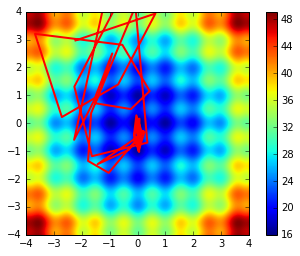

In [22]:
# Plot the Rastrigin function and the path taken by the tracked particle
lim = 4  # We will plot the Rastrigin function in an x-y square centered at 0 with this as the max value 
stepsize = 0.01
x_axis = np.linspace(-lim,lim,lim/stepsize+1)
y_axis = np.linspace(-lim,lim,lim/stepsize+1)
x,y = np.meshgrid(x_axis, y_axis)  # This produces arrays of the same size which will vary in x and y appropriately
f = 20 + np.multiply(x,x) + np.multiply(y,y) - 2*np.cos(2*np.pi*x) - 2*np.cos(2*np.pi*y)
plt.plot(trackData[:,0],trackData[:,1],'r',lw=2)
plt.imshow(f, extent = [-lim, lim, -lim, lim])
plt.xticks(np.linspace(-lim,lim,2*lim+1))
plt.yticks(np.linspace(-lim,lim,2*lim+1))
plt.colorbar()